In [1]:
!pip install librosa scikit-learn matplotlib seaborn tqdm

  Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
  Using cached scikit_learn-1.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.9 MB)
  Using cached matplotlib-3.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
  Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 3.7 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
  Using cached numba-0.61.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.8 MB)
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)
  Using cached msgpack-1.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (408 kB)
  Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
  Using cached soxr-0.5.

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from tqdm import tqdm

In [2]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def parse_metadata(root_folder):
    data = []
    for actor_folder in os.listdir(root_folder):
        actor_path = os.path.join(root_folder, actor_folder)
        for file in os.listdir(actor_path):
            if not file.endswith('.wav'):
                continue
            parts = file.split('.')[0].split('-')
            emotion = emotion_map.get(parts[2])
            actor_id = int(parts[6])
            gender = 'female' if actor_id % 2 == 0 else 'male'
            filepath = os.path.join(actor_path, file)
            data.append([filepath, emotion, gender, actor_id])
    return pd.DataFrame(data, columns=["filepath", "emotion", "gender", "actor_id"])

speech_df = parse_metadata('data/speech_actors')
song_df = parse_metadata('data/song_actors')
df = pd.concat([speech_df, song_df], ignore_index=True)

print("\n🎭 Emotion label distribution:")
print(df['emotion'].value_counts())

print("Total audio-only .wav files:", len(df))
df.head()



🎭 Emotion label distribution:
emotion
calm         376
happy        376
sad          376
angry        376
fearful      376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64
Total audio-only .wav files: 2452


,filepath,emotion,gender,actor_id
0,data/speech_actors/Actor_01/03-01-01-01-01-01-...,neutral,male,1
1,data/speech_actors/Actor_01/03-01-01-01-01-02-...,neutral,male,1
2,data/speech_actors/Actor_01/03-01-01-01-02-01-...,neutral,male,1
3,data/speech_actors/Actor_01/03-01-01-01-02-02-...,neutral,male,1
4,data/speech_actors/Actor_01/03-01-02-01-01-01-...,calm,male,1


## 1. Random Forest


In [3]:
def extract_features(path, n_mfcc=40): #Mel-frequency cepstral coefficients 
    y, sr = librosa.load(path, sr=None)

    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0) #Spectral contrast
    zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0) #Zero crossing rate
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)

    return np.hstack([mfcc, chroma, contrast, zcr, rms])

# Extract features and labels
features = []
labels = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        feat = extract_features(row['filepath'])
        features.append(feat)
        labels.append(row['emotion'])
    except Exception as e:
        print(f"Failed for {row['filepath']}: {e}")

X = np.array(features)
y = np.array(labels)

print("Shape of feature matrix:", X.shape)



100%|██████████| 2452/2452 [05:04<00:00,  8.06it/s]

Shape of feature matrix: (2452, 61)


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42 # Stratified split to maintain class distribution
)
print(f"🔹 Total training samples: {len(X_train)}")
print(f"🔹 Total validation samples: {len(X_val)}")

🔹 Total training samples: 1961
🔹 Total validation samples: 491


In [5]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Overall Accuracy: 73.73%

Precision, Recall, F1-score:
              precision    recall  f1-score   support

       angry       0.85      0.81      0.83        75
        calm       0.74      0.89      0.81        75
     disgust       0.64      0.64      0.64        39
     fearful       0.68      0.68      0.68        75
       happy       0.75      0.73      0.74        75
     neutral       0.84      0.71      0.77        38
         sad       0.71      0.71      0.71        75
   surprised       0.68      0.59      0.63        39

    accuracy                           0.74       491
   macro avg       0.74      0.72      0.73       491
weighted avg       0.74      0.74      0.74       491



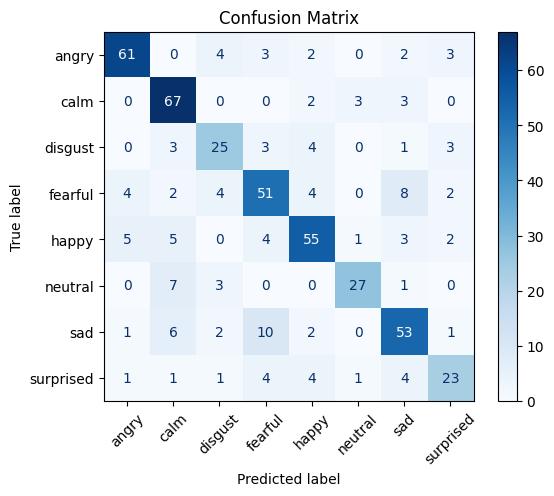


Per-Class Accuracy:
angry     : 81.33%
calm      : 89.33%
disgust   : 64.10%
fearful   : 68.00%
happy     : 73.33%
neutral   : 71.05%
sad       : 70.67%
surprised : 58.97%


In [8]:
y_pred = clf.predict(X_val)

overall_acc = accuracy_score(y_val, y_pred)
print(f"Overall Accuracy: {overall_acc * 100:.2f}%\n")

print("Precision, Recall, F1-score:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print("\nPer-Class Accuracy:")
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for label, acc in zip(clf.classes_, class_accuracy):
    print(f"{label:10s}: {acc * 100:.2f}%")

## 2. Comparing Performance of CNN, CNN+LSTM and CNN+GRU


In [8]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 2.0 MB/s eta 0:00:00m eta 0:00:010:00:05
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 4.1 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 3.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.1 MB/s eta 0:00:00m eta 0:00:010:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 8.0 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 4.1 MB/s eta 0:00:00m eta 0:00:010:01:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 4.1 MB/s eta 0:00:00m eta 0:00:010:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 4.0 MB/s eta 

In [3]:
import pyloudnorm as pyln
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate
)

2025-06-25 03:11:49.401388: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 03:11:49.419561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750801309.434910  115732 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750801309.438973  115732 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750801309.449639  115732 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
meter = pyln.Meter(22050) # Loudness meter using ITU-R BS.1770 standard
MAX_LEN = 200
N_MFCC = 40

def estimate_snr(y):
    signal_power = np.mean(y**2)
    noise_power = np.var(y - np.mean(y))
    return 10 * np.log10(signal_power / (noise_power + 1e-12))

def extract_features_advanced(path, max_len=200, n_mfcc=40):
    y, sr = librosa.load(path, sr=22050)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T
    chroma = librosa.feature.chroma_stft(y=y, sr=sr).T
    zcr = librosa.feature.zero_crossing_rate(y).T
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr).T

    features = np.hstack([
        mfcc[:max_len], 
        chroma[:max_len], 
        zcr[:max_len], 
        contrast[:max_len]
    ])
    
    meter = pyln.Meter(sr)
    duration = librosa.get_duration(y=y, sr=sr)
    loudness = meter.integrated_loudness(y)
    rms = np.sqrt(np.mean(y**2))
    peak = np.max(np.abs(y))
    snr = estimate_snr(y)
    silence_pct = np.sum(np.abs(y) < 0.001) / len(y)
    
    global_stats = np.array([duration, loudness, rms, peak, snr, silence_pct])
    return features, global_stats


In [6]:
X_seq, X_stats, y = [], [], []

for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        feat_seq, stats = extract_features_advanced(row['filepath'])
        X_seq.append(feat_seq)
        X_stats.append(stats)
        y.append(row['emotion'])
    except Exception as e:
        print(f"Error with {row['filepath']}: {e}")

X_seq_padded = pad_sequences(X_seq, maxlen=200, dtype='float32', padding='post')
X_stats_np = np.array(X_stats)

100%|██████████| 2452/2452 [03:45<00:00, 10.86it/s]


In [7]:
scaler = StandardScaler()
X_stats_scaled = scaler.fit_transform(X_stats_np)

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

In [8]:
X_train_seq, X_val_seq, X_train_stats, X_val_stats, y_train, y_val = train_test_split(
    X_seq_padded, X_stats_scaled, y_cat,
    test_size=0.2, stratify=y_encoded, random_state=42
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, min_delta=0.001, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

In [10]:
def build_cnn_model(input_shape, stats_shape, n_classes):
    input_seq = Input(shape=input_shape)
    x = Conv1D(128, 3, activation='relu')(input_seq)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.4)(x)

    x = Conv1D(256, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)

    input_stats = Input(shape=stats_shape)
    merged = Concatenate()([x, input_stats])
    z = Dense(128, activation='relu')(merged)
    z = Dropout(0.3)(z)
    output = Dense(n_classes, activation='softmax')(z)

    model = Model([input_seq, input_stats], output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [15]:
def build_cnn_lstm_model(input_shape, stats_shape, n_classes):
    input_seq = Input(shape=input_shape)
    x = Conv1D(128, 3, activation='relu')(input_seq)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.4)(x)

    x = LSTM(128)(x)

    input_stats = Input(shape=stats_shape)
    merged = Concatenate()([x, input_stats])
    z = Dense(128, activation='relu')(merged)
    z = Dropout(0.4)(z)
    output = Dense(n_classes, activation='softmax')(z)

    model = Model([input_seq, input_stats], output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
from tensorflow.keras.layers import GRU, BatchNormalization, Flatten

def build_cnn_gru_model(input_shape, stats_shape, n_classes):
    input_seq = Input(shape=input_shape)
    x = Conv1D(128, 3, activation='relu')(input_seq)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.5)(x)

    x = GRU(128)(x)

    input_stats = Input(shape=stats_shape)
    merged = Concatenate()([x, input_stats])
    z = Dense(128, activation='relu')(merged)
    z = Dropout(0.5)(z)
    output = Dense(n_classes, activation='softmax')(z)

    model = Model([input_seq, input_stats], output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [13]:
cnn_model = build_cnn_model(X_train_seq.shape[1:], X_train_stats.shape[1:], y_train.shape[1])

print("Training model: CNN")
history_cnn = cnn_model.fit(
    [X_train_seq, X_train_stats], y_train,
    validation_data=([X_val_seq, X_val_stats], y_val),
    epochs=100, batch_size=32,
    callbacks=callbacks,
    verbose=1
)


2025-06-25 03:16:09.180312: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-25 03:16:09.180341: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-06-25 03:16:09.180347: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: ayush-82k1
2025-06-25 03:16:09.180350: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: ayush-82k1
2025-06-25 03:16:09.180556: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 575.64.0
2025-06-25 03:16:09.180593: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported

Training model: CNN
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.2516 - loss: 2.8024 - val_accuracy: 0.1731 - val_loss: 3.2570 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.4320 - loss: 1.4263 - val_accuracy: 0.5071 - val_loss: 1.3048 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5018 - loss: 1.3065 - val_accuracy: 0.5580 - val_loss: 1.2066 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.5849 - loss: 1.0948 - val_accuracy: 0.4807 - val_loss: 1.7074 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.6178 - loss: 1.0542 - val_accuracy: 0.5458 - val_loss: 1.2346 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6511 - loss: 0.9333 - val_accuracy: 0.6049 - val_loss: 1.0992 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Classification Report: CNN Only
              precision    recall  f1-score   support

       angry       0.88      0.87      0.87        75
        calm       0.88      0.84      0.86        75
     disgust       0.77      0.69      0.73        39
     fearful       0.78      0.81      0.80        75
       happy       0.78      0.84      0.81        75
     neutral       0.82      0.84      0.83        38
         sad       0.76      0.75      0.75        75
   surprised       0.71      0.69      0.70        39

    accuracy                           0.80       491
   macro avg       0.80      0.79      0.79       491
weighted avg       0.80      0.80      0.80       491



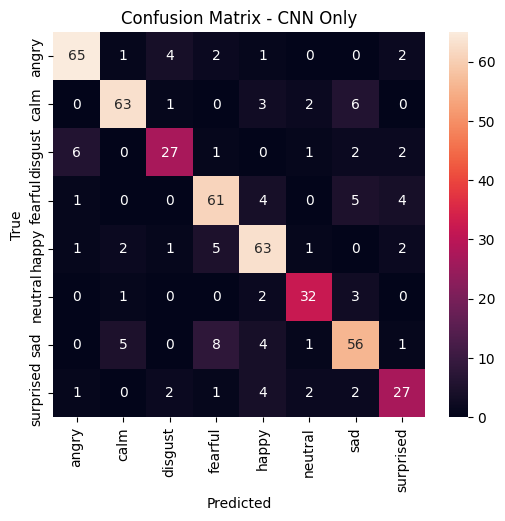

In [16]:
y_pred_cnn = np.argmax(cnn_model.predict([X_val_seq, X_val_stats]), axis=1)
y_true = np.argmax(y_val, axis=1)

print("Classification Report: CNN Only")
print(classification_report(y_true, y_pred_cnn, target_names=le.classes_))

cm_cnn = confusion_matrix(y_true, y_pred_cnn)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cnn, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - CNN Only")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
cnn_lstm_model = build_cnn_lstm_model(X_train_seq.shape[1:], X_train_stats.shape[1:], y_train.shape[1])

print("Training model: CNN + LSTM")
history_cnn_lstm = cnn_lstm_model.fit(
    [X_train_seq, X_train_stats], y_train,
    validation_data=([X_val_seq, X_val_stats], y_val),
    epochs=100, batch_size=32,
    callbacks=callbacks,
    verbose=1
)

🔧 Training model: CNN + LSTM
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.2127 - loss: 1.9787 - val_accuracy: 0.3014 - val_loss: 1.8158 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.2876 - loss: 1.7574 - val_accuracy: 0.3564 - val_loss: 1.7024 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.3247 - loss: 1.6554 - val_accuracy: 0.3442 - val_loss: 1.6247 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.3500 - loss: 1.5832 - val_accuracy: 0.3259 - val_loss: 1.6787 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.3524 - loss: 1.5730 - val_accuracy: 0.3340 - val_loss: 1.6220 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.3724 - loss: 1.5553 - val_accuracy: 0.3727 - val_loss: 1.5259 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
Classification Report: CNN + LSTM
              precision    recall  f1-score   support

       angry       0.83      0.93      0.88        75
        calm       0.84      0.87      0.86        75
     disgust       0.81      0.87      0.84        39
     fearful       0.85      0.67      0.75        75
       happy       0.93      0.85      0.89        75
     neutral       0.75      0.79      0.77        38
         sad       0.73      0.81      0.77        75
   surprised       0.78      0.72      0.75        39

    accuracy                           0.82       491
   macro avg       0.81      0.81      0.81       491
weighted avg       0.82      0.82      0.82       491



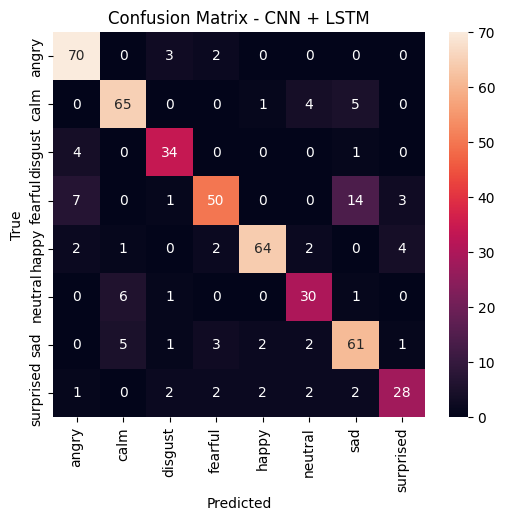

In [18]:
y_pred_lstm = np.argmax(cnn_lstm_model.predict([X_val_seq, X_val_stats]), axis=1)

print("Classification Report: CNN + LSTM")
print(classification_report(y_true, y_pred_lstm, target_names=le.classes_))

cm_lstm = confusion_matrix(y_true, y_pred_lstm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_lstm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - CNN + LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [19]:
cnn_gru_model = build_cnn_gru_model(X_train_seq.shape[1:], X_train_stats.shape[1:], y_train.shape[1])

print("Training model: CNN + GRU")
history_cnn_gru = cnn_gru_model.fit(
    [X_train_seq, X_train_stats], y_train,
    validation_data=([X_val_seq, X_val_stats], y_val),
    epochs=100, batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Training model: CNN + GRU
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.2049 - loss: 2.1253 - val_accuracy: 0.2485 - val_loss: 2.0017 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.2717 - loss: 1.8192 - val_accuracy: 0.3136 - val_loss: 1.7381 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.2877 - loss: 1.7818 - val_accuracy: 0.2851 - val_loss: 1.7096 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.2806 - loss: 1.7412 - val_accuracy: 0.3462 - val_loss: 1.6625 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.2992 - loss: 1.7142 - val_accuracy: 0.3136 - val_loss: 1.6811 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.3087 - loss: 1.6773 - val_accuracy: 0.3238 - val_loss: 1.7026 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Classification Report: CNN + GRU
              precision    recall  f1-score   support

       angry       0.86      0.93      0.90        75
        calm       0.93      0.87      0.90        75
     disgust       0.87      0.87      0.87        39
     fearful       0.79      0.77      0.78        75
       happy       0.85      0.80      0.82        75
     neutral       0.79      0.87      0.82        38
         sad       0.75      0.81      0.78        75
   surprised       0.82      0.72      0.77        39

    accuracy                           0.83       491
   macro avg       0.83      0.83      0.83       491
weighted avg       0.83      0.83      0.83       491



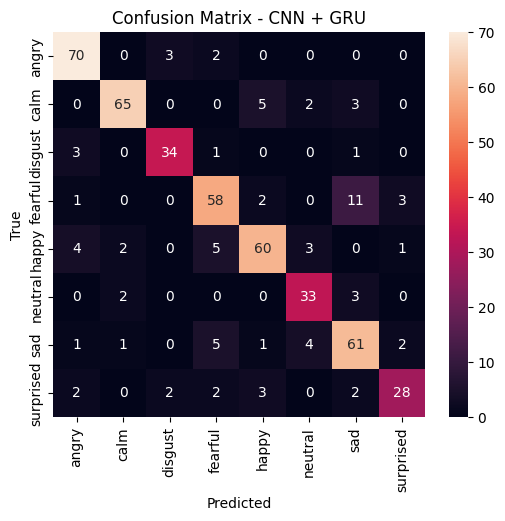

In [20]:
y_pred_gru = np.argmax(cnn_gru_model.predict([X_val_seq, X_val_stats]), axis=1)

print("Classification Report: CNN + GRU")
print(classification_report(y_true, y_pred_gru, target_names=le.classes_))

cm_gru = confusion_matrix(y_true, y_pred_gru)
plt.figure(figsize=(6,5))
sns.heatmap(cm_gru, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - CNN + GRU")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## 3. Wav2Vec2


In [3]:
from sklearn.preprocessing import LabelEncoder
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [4]:
from transformers import Wav2Vec2Processor

MODEL_NAME = "facebook/wav2vec2-base"
processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)

/home/ayush/Projects/mars-open-project/.venv-wav2vec/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ayush/Projects/mars-open-project/.venv-wav2vec/lib/python3.13/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [ ]:
# Create the encoder
le = LabelEncoder()

# Fit and transform the 'emotion' column into numeric labels
df['label'] = le.fit_transform(df['emotion'])

print("Label mapping:")
for i, label in enumerate(le.classes_):
    print(f"{i}: {label}")

Label mapping:
0: angry
1: calm
2: disgust
3: fearful
4: happy
5: neutral
6: sad
7: surprised


In [ ]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Config

num_labels = len(le.classes_)  

config = Wav2Vec2Config.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    finetuning_task="emotion-classification",
    problem_type="single_label_classification"
)

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config
)


/home/ayush/Projects/mars-open-project/.venv-wav2vec/lib/python3.13/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import Dataset
import torchaudio
import torch

class EmotionDataset(Dataset):
    def __init__(self, df, processor, max_len=4):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.max_len = max_len * 16000  # 4 seconds at 16kHz

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            waveform, sr = torchaudio.load(row['filepath'])
        except Exception as e:
            print(f"Failed at index {idx} with {row['filepath']}: {e}")


        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0)
        else:
            waveform = waveform.squeeze()

        # Resample to 16kHz 
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
            waveform = resampler(waveform)

        # Truncate or pad to fixed length
        if len(waveform) > self.max_len:
            waveform = waveform[:self.max_len]
        else:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_len - len(waveform)))

        # Tokenize using processor
        inputs = self.processor(waveform, sampling_rate=16000, return_tensors="pt")

        # print(f"input_values shape: {inputs['input_values'].shape}")  # Should be [1, sequence_length]
        # print(waveform.dtype, waveform.shape)


        return {
            "input_values": inputs["input_values"].squeeze(0),  # Shape: [sequence_length]
            "labels": torch.tensor(row['label'], dtype=torch.long)
        }

In [8]:
dataset = EmotionDataset(df, processor)
sample = dataset[0]  # This will trigger __getitem__ and show the print
df['label'].value_counts()



label
1    376
4    376
6    376
0    376
3    376
2    192
7    192
5    188
Name: count, dtype: int64

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_dataset = EmotionDataset(train_df, processor)
val_dataset = EmotionDataset(val_df, processor)

In [9]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(
    tokenizer=processor,
    padding=True
)

In [10]:
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')

    report = classification_report(labels, preds, target_names=le.classes_, output_dict=True)
    
    # Print per-class accuracy and F1 for debugging
    print("\n📄 Classification Report:")
    print(classification_report(labels, preds, target_names=le.classes_))

    return {
        "accuracy": acc,
        "f1": f1,
    }

In [11]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./wav2vec2-emotion",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    save_total_limit=2,
    num_train_epochs=12,
    learning_rate=1e-5,
    warmup_steps=200,
    weight_decay=0.005,
    fp16=True,  # Mixed precision
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",  # disable wandb/huggingface logging
    dataloader_num_workers=0, 
)

In [12]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor.feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_3783/4030499088.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [32]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
# model = model.to("cuda")

In [13]:
from transformers import Trainer

print(trainer.args.device)

cuda:0


In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.444900,1.464654,0.498982,0.445278
2,0.397200,1.124674,0.704684,0.691974
3,1.235200,1.330224,0.727088,0.715099
4,0.140300,1.056995,0.816701,0.814765
5,0.766400,1.129542,0.828921,0.831772
6,0.000800,1.297568,0.824847,0.826309
7,0.000700,1.039308,0.867617,0.868102
8,0.000300,1.374958,0.828921,0.828265
9,0.000300,1.028826,0.881874,0.881853
10,0.000100,0.995476,0.890020,0.890536



📄 Classification Report:
              precision    recall  f1-score   support

       angry       0.51      0.95      0.66        75
        calm       0.77      0.67      0.71        75
     disgust       0.52      0.56      0.54        39
     fearful       0.46      0.73      0.56        75
       happy       0.60      0.08      0.14        75
     neutral       1.00      0.03      0.05        38
         sad       0.49      0.25      0.33        75
   surprised       0.28      0.54      0.37        39

    accuracy                           0.50       491
   macro avg       0.58      0.48      0.42       491
weighted avg       0.57      0.50      0.45       491


📄 Classification Report:
              precision    recall  f1-score   support

       angry       0.91      0.89      0.90        75
        calm       0.68      0.79      0.73        75
     disgust       0.84      0.79      0.82        39
     fearful       0.55      0.95      0.70        75
       happy       0.72   

TrainOutput(global_step=23532, training_loss=0.4850969572932911, metrics={'train_runtime': 3361.2239, 'train_samples_per_second': 7.001, 'train_steps_per_second': 7.001, 'total_flos': 8.54567467094016e+17, 'train_loss': 0.4850969572932911, 'epoch': 12.0})

In [15]:
model.save_pretrained("saved_model/emotion_wav2vec2")
processor.save_pretrained("saved_model/emotion_wav2vec2")

[]

📄 Classification Report: Wav2Vec2
              precision    recall  f1-score   support

       angry       0.97      0.96      0.97        75
        calm       0.92      0.80      0.86        75
     disgust       0.93      0.97      0.95        39
     fearful       0.94      0.89      0.92        75
       happy       0.85      0.92      0.88        75
     neutral       0.75      0.95      0.84        38
         sad       0.82      0.84      0.83        75
   surprised       0.97      0.85      0.90        39

    accuracy                           0.89       491
   macro avg       0.89      0.90      0.89       491
weighted avg       0.90      0.89      0.89       491



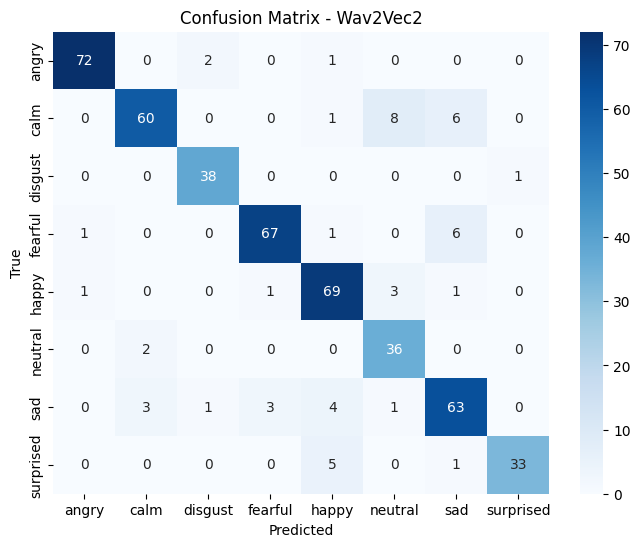

In [ ]:
model.eval()

y_true = []
y_pred = []

for item in val_dataset:
    input_values = item['input_values'].unsqueeze(0)  
    with torch.no_grad():
        logits = model(input_values).logits
        pred = torch.argmax(logits, dim=-1).item()
    
    y_pred.append(pred)
    y_true.append(item['labels'].item())

print("📄 Classification Report: Wav2Vec2")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix - Wav2Vec2")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()